In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import re
import sys
import json
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Optional, Tuple

In [5]:
def parse_bpp_from_experiment(exp_name: str) -> Optional[int]:
    parts = exp_name.split("_")
    
    if parts[0] == "1" and parts[1] == '1':
        return 1
    elif parts[0] == "1" and parts[1] == '3':
        return 3
    elif parts[0] == "3" and parts[1] == '3' and "stegformer" in exp_name.lower():
        return 3
    elif parts[0] == "3" and parts[1] == '3':
        return 6
    elif parts[0] == "15" and parts[1] == '2':
        return 8
    else:
        print(f"[WARN] Could not parse bpp from experiment name: {exp_name}")
        return None

def find_distance_files(dist_dir: Path, metric: str, mode: str) -> Dict[Tuple[str, str], Path]:
    """
    Return mapping {(condition, pair_type) -> file_path} if exists.
    Supports offline & online suffixes.
    Condition: OO, OW, WW
    Pair type: genuine, impostor
    """
    if mode == 'online':
        patterns = {
            ("OO", "genuine"):   [f"{metric}_genuine_distances_baseline_online.csv"],
            ("OO", "impostor"):  [f"{metric}_impostor_distances_baseline_online.csv"],
            ("OW", "genuine"):   [f"{metric}_genuine_distances_watermarked_online.csv"],
            ("OW", "impostor"):  [f"{metric}_impostor_distances_watermarked_online.csv"],
            ("WW", "genuine"):   [f"{metric}_genuine_distances_watermarked_both_online.csv"],
            ("WW", "impostor"):  [f"{metric}_impostor_distances_watermarked_both_online.csv"],
        }
    else:
        patterns = {
            ("OO", "genuine"):   [f"{metric}_genuine_distances_baseline.csv"],
            ("OO", "impostor"):  [f"{metric}_impostor_distances_baseline.csv"],
            ("OW", "genuine"):   [f"{metric}_genuine_distances_watermarked.csv"],
            ("OW", "impostor"):  [f"{metric}_impostor_distances_watermarked.csv"],
            ("WW", "genuine"):   [f"{metric}_genuine_distances_watermarked_both.csv"],
            ("WW", "impostor"):  [f"{metric}_impostor_distances_watermarked_both.csv"],
        }
    out = {}
    for key, candidates in patterns.items():
        for name in candidates:
            p = dist_dir / name
            if p.is_file():
                out[key] = p
                break
    return out


def read_distance_column(csv_path: Path) -> np.ndarray:
    """
    Reads a CSV that may have header or multiple columns and returns a 1D float array.
    Prefers columns named ['distance','dist','score']; otherwise picks the column with most numeric values.
    """
    df = pd.read_csv(csv_path, sep=None, engine="python")
    if df.shape[1] == 1:
        s = pd.to_numeric(df.iloc[:, 0], errors="coerce")
        return s.dropna().to_numpy(dtype=float)
    preferred = [c for c in df.columns if str(c).strip().lower() in {"distance", "dist", "score"}]
    if preferred:
        s = pd.to_numeric(df[preferred[0]], errors="coerce")
        return s.dropna().to_numpy(dtype=float)
    # fallback: pick the numerically richest column
    best = None; best_count = -1
    for c in df.columns:
        s = pd.to_numeric(df[c], errors="coerce")
        count = s.notna().sum()
        if count > best_count:
            best_count = count; best = s
    return best.dropna().to_numpy(dtype=float)


def collect_records(root: Path, watermark: str, recognizer: str, metric: str,
                    train_filter: Optional[str] = None,
                    test_filter: Optional[List[str]] = None,
                    mode = str) -> List[Dict]:
    """
    Walks the directory tree and collects long-form records.
    Expected layout:
      root / <watermark> / <experiment> / <train_dataset> / <test_dataset> / <recognizer> / distances / *.csv
    """
    records: List[Dict] = []

    algo_dir = root / watermark
    if not algo_dir.is_dir():
        raise FileNotFoundError(f"Algorithm dir not found: {algo_dir}")

    for exp_dir in sorted([p for p in algo_dir.iterdir() if p.is_dir()]):
        bpp = parse_bpp_from_experiment(exp_dir.name)
        # If bpp can't be inferred, skip (avoid polluting stats)
        if bpp is None:
            continue

        # <train_dataset> dirs
        for train_dir in sorted([p for p in exp_dir.iterdir() if p.is_dir()]):
            train_dataset = train_dir.name
            if train_filter and train_dataset.lower() != train_filter.lower():
                continue

            # <test_dataset> dirs
            for test_dir in sorted([p for p in train_dir.iterdir() if p.is_dir()]):
                test_dataset = test_dir.name
                if test_filter and test_dataset not in test_filter:
                    continue

                recog_dir = test_dir / recognizer / "distances"
                if not recog_dir.is_dir():
                    # some structures store distances directly under recognizer
                    recog_dir = test_dir / recognizer
                if not recog_dir.is_dir():
                    # Nothing to do
                    continue

                files = find_distance_files(recog_dir, metric=metric, mode=mode)
                if not files:
                    continue

                for (condition, pair_type), csv_path in files.items():
                    try:
                        arr = read_distance_column(csv_path)
                        if arr.size == 0:
                            continue
                        for val in arr:
                            records.append({
                                "watermark": watermark,
                                "recognizer": recognizer,
                                "metric": metric,
                                "train_dataset": train_dataset,
                                "test_dataset": test_dataset,
                                "bpp": int(bpp),
                                "condition": condition,    # OO, OW, WW
                                "pair_type": pair_type,    # genuine, impostor
                                "distance": float(val),
                                "experiment": exp_dir.name,
                                "path": str(csv_path)
                            })
                    except Exception as e:
                        print(f"[WARN] Failed reading {csv_path}: {e}")
                        continue
    return records


In [6]:
root = r'C:\Users\JotaR\Documents\Github\WAFIS-ICAOeval\experiments\output\recognition'
watermark = 'stegaformer'
recognizer = 'facenet'
mode = 'online'
test_datasets = ['CFD', 'facelab_london', 'LFW', 'ONOT']
metric = 'cosine'
train_dataset_filter = 'coco'
root = Path(root)

# 1) Collect long-form records
records = collect_records(root, watermark, recognizer, metric,
                              train_filter=train_dataset_filter,
                              test_filter=set(test_datasets) if test_datasets else None,
                              mode=mode)

In [8]:
df_long = pd.DataFrame.from_records(records)

df_long

,watermark,recognizer,metric,train_dataset,test_dataset,bpp,condition,pair_type,distance,experiment,path
0,stegaformer,facenet,cosine,coco,CFD,8,OO,genuine,0.109063,15_2_255_w16_learn_im,C:\Users\JotaR\Documents\Github\WAFIS-ICAOeval...
1,stegaformer,facenet,cosine,coco,CFD,8,OO,genuine,0.081616,15_2_255_w16_learn_im,C:\Users\JotaR\Documents\Github\WAFIS-ICAOeval...
2,stegaformer,facenet,cosine,coco,CFD,8,OO,genuine,0.219615,15_2_255_w16_learn_im,C:\Users\JotaR\Documents\Github\WAFIS-ICAOeval...
3,stegaformer,facenet,cosine,coco,CFD,8,OO,genuine,0.070410,15_2_255_w16_learn_im,C:\Users\JotaR\Documents\Github\WAFIS-ICAOeval...
4,stegaformer,facenet,cosine,coco,CFD,8,OO,genuine,0.104042,15_2_255_w16_learn_im,C:\Users\JotaR\Documents\Github\WAFIS-ICAOeval...
...,...,...,...,...,...,...,...,...,...,...,...
17252743,stegaformer,facenet,cosine,coco,ONOT,6,WW,impostor,0.869666,3_3_255_w16_learn_im,C:\Users\JotaR\Documents\Github\WAFIS-ICAOeval...
17252744,stegaformer,facenet,cosine,coco,ONOT,6,WW,impostor,0.641564,3_3_255_w16_learn_im,C:\Users\JotaR\Documents\Github\WAFIS-ICAOeval...
17252745,stegaformer,facenet,cosine,coco,ONOT,6,WW,impostor,0.732840,3_3_255_w16_learn_im,C:\Users\JotaR\Documents\Github\WAFIS-ICAOeval...
17252746,stegaformer,facenet,cosine,coco,ONOT,6,WW,impostor,0.692435,3_3_255_w16_learn_im,C:\Users\JotaR\Documents\Github\WAFIS-ICAOeval...


In [9]:
unique_paths = df_long.path.unique()

In [10]:
unique_paths.shape

(96,)

In [45]:
df_long.tail(15).values

array([['stegaformer', 'facenet', 'cosine', 'coco', 'ONOT', 6, 'WW',
        'impostor', 1.0388385728001597, '3_3_255_w16_learn_im',
        'C:\\Users\\JotaR\\Documents\\Github\\WAFIS-ICAOeval\\experiments\\output\\recognition\\stegaformer\\3_3_255_w16_learn_im\\coco\\ONOT\\facenet\\distances\\cosine_impostor_distances_watermarked_both_online.csv'],
       ['stegaformer', 'facenet', 'cosine', 'coco', 'ONOT', 6, 'WW',
        'impostor', 0.7996960580348969, '3_3_255_w16_learn_im',
        'C:\\Users\\JotaR\\Documents\\Github\\WAFIS-ICAOeval\\experiments\\output\\recognition\\stegaformer\\3_3_255_w16_learn_im\\coco\\ONOT\\facenet\\distances\\cosine_impostor_distances_watermarked_both_online.csv'],
       ['stegaformer', 'facenet', 'cosine', 'coco', 'ONOT', 6, 'WW',
        'impostor', 0.802257627248764, '3_3_255_w16_learn_im',
        'C:\\Users\\JotaR\\Documents\\Github\\WAFIS-ICAOeval\\experiments\\output\\recognition\\stegaformer\\3_3_255_w16_learn_im\\coco\\ONOT\\facenet\\distances\

In [11]:
def compute_group_stats(df_long: pd.DataFrame) -> pd.DataFrame:
    group_cols = ["watermark","recognizer","metric","train_dataset","test_dataset","bpp","condition","pair_type"]
    agg = (
        df_long
        .groupby(group_cols)
        .agg(
            mean_dist=("distance","mean"),
            std_dist=("distance","std"),
            p99=("distance", lambda x: x.quantile(0.95)),
            p999=("distance", lambda x: x.quantile(0.999)),
            p9999=("distance", lambda x: x.quantile(0.9999)),
            p01=("distance", lambda x: x.quantile(0.01)),
            p001=("distance", lambda x: x.quantile(0.001)),
            p0001=("distance", lambda x: x.quantile(0.0001)),
            n=("distance","count"),
        )
        .reset_index()
    )
    return agg

In [12]:
# 2) Compute stats
stats = compute_group_stats(df_long)

In [13]:
genuine_cols = ['train_dataset','test_dataset','bpp','condition','pair_type','mean_dist','std_dist','p99','p999','p9999','n']
impostor_cols = ['train_dataset','test_dataset','bpp','condition','pair_type','mean_dist','std_dist','p01','p001','p0001','n']

In [14]:
stats

,watermark,recognizer,metric,train_dataset,test_dataset,bpp,condition,pair_type,mean_dist,std_dist,p99,p999,p9999,p01,p001,p0001,n
0,stegaformer,facenet,cosine,coco,CFD,1,OO,genuine,0.113694,0.042561,0.190967,0.331412,0.350151,0.050048,0.041411,0.040166,158
1,stegaformer,facenet,cosine,coco,CFD,1,OO,impostor,0.898125,0.183686,1.180110,1.363606,1.422391,0.437966,0.320698,0.256474,12403
2,stegaformer,facenet,cosine,coco,CFD,1,OW,genuine,0.114248,0.044573,0.192821,0.317775,0.332287,0.048490,0.036342,0.034349,158
3,stegaformer,facenet,cosine,coco,CFD,1,OW,impostor,0.899789,0.183556,1.183016,1.371056,1.430914,0.433491,0.320966,0.245387,12403
4,stegaformer,facenet,cosine,coco,CFD,1,WW,genuine,0.107636,0.043260,0.185416,0.306177,0.315306,0.048141,0.036887,0.035010,158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,stegaformer,facenet,cosine,coco,facelab_london,8,OO,impostor,0.948671,0.155977,1.197416,1.410789,1.489255,0.571291,0.441299,0.280514,5151
92,stegaformer,facenet,cosine,coco,facelab_london,8,OW,genuine,0.071355,0.036964,0.136270,0.215956,0.216058,0.025703,0.014635,0.013518,102
93,stegaformer,facenet,cosine,coco,facelab_london,8,OW,impostor,0.950783,0.155426,1.198838,1.394616,1.488475,0.566526,0.449433,0.309880,5151
94,stegaformer,facenet,cosine,coco,facelab_london,8,WW,genuine,0.060376,0.033636,0.117811,0.199675,0.200457,0.012441,0.011587,0.011506,102


In [15]:
stats[(stats['test_dataset']=='ONOT')&(stats['pair_type']=='genuine')][genuine_cols]

,train_dataset,test_dataset,bpp,condition,pair_type,mean_dist,std_dist,p99,p999,p9999,n
48,coco,ONOT,1,OO,genuine,0.236858,0.095662,0.416879,0.500390,0.506856,125
50,coco,ONOT,1,OW,genuine,0.236197,0.095944,0.404725,0.514598,0.518739,125
52,coco,ONOT,1,WW,genuine,0.232929,0.092273,0.389775,0.511784,0.520397,125
54,coco,ONOT,3,OO,genuine,0.236858,0.095662,0.416879,0.500390,0.506856,125
56,coco,ONOT,3,OW,genuine,0.236215,0.095291,0.406693,0.514436,0.518603,125
58,coco,ONOT,3,WW,genuine,0.233330,0.092629,0.394814,0.539671,0.551135,125
60,coco,ONOT,6,OO,genuine,0.236858,0.095662,0.416879,0.500390,0.506856,125
62,coco,ONOT,6,OW,genuine,0.236601,0.095191,0.416204,0.527488,0.532585,125
64,coco,ONOT,6,WW,genuine,0.233711,0.092307,0.406527,0.547702,0.563057,125
66,coco,ONOT,8,OO,genuine,0.236858,0.095662,0.416879,0.500390,0.506856,125


In [16]:
stats[(stats['test_dataset']=='ONOT')&(stats['pair_type']=='impostor')][impostor_cols]

,train_dataset,test_dataset,bpp,condition,pair_type,mean_dist,std_dist,p01,p001,p0001,n
49,coco,ONOT,1,OO,impostor,0.835483,0.194504,0.335757,0.230193,0.161458,7750
51,coco,ONOT,1,OW,impostor,0.832833,0.193875,0.338161,0.235299,0.167350,7750
53,coco,ONOT,1,WW,impostor,0.832858,0.194006,0.339006,0.218921,0.173702,7750
55,coco,ONOT,3,OO,impostor,0.835483,0.194504,0.335757,0.230193,0.161458,7750
57,coco,ONOT,3,OW,impostor,0.832481,0.194092,0.337337,0.236397,0.167616,7750
59,coco,ONOT,3,WW,impostor,0.832490,0.194452,0.338656,0.223936,0.172486,7750
61,coco,ONOT,6,OO,impostor,0.835483,0.194504,0.335757,0.230193,0.161458,7750
63,coco,ONOT,6,OW,impostor,0.833329,0.194660,0.335476,0.234712,0.154054,7750
65,coco,ONOT,6,WW,impostor,0.832888,0.194297,0.336344,0.226196,0.155414,7750
67,coco,ONOT,8,OO,impostor,0.835483,0.194504,0.335757,0.230193,0.161458,7750


In [17]:
stats[(stats['test_dataset']=='LFW')&(stats['pair_type']=='genuine')][genuine_cols]

,train_dataset,test_dataset,bpp,condition,pair_type,mean_dist,std_dist,p99,p999,p9999,n
24,coco,LFW,1,OO,genuine,0.275788,0.185740,0.589933,1.246686,1.284549,1680
26,coco,LFW,1,OW,genuine,0.286221,0.189941,0.642858,1.256919,1.298677,1680
28,coco,LFW,1,WW,genuine,0.277550,0.190521,0.647701,1.278002,1.294490,1680
30,coco,LFW,3,OO,genuine,0.275788,0.185740,0.589933,1.246686,1.284549,1680
32,coco,LFW,3,OW,genuine,0.285531,0.189116,0.640223,1.256888,1.299220,1680
34,coco,LFW,3,WW,genuine,0.277947,0.191713,0.654275,1.279646,1.283372,1680
36,coco,LFW,6,OO,genuine,0.275788,0.185740,0.589933,1.246686,1.284549,1680
38,coco,LFW,6,OW,genuine,0.284775,0.187785,0.628424,1.258048,1.300034,1680
40,coco,LFW,6,WW,genuine,0.277658,0.191410,0.638745,1.276801,1.282992,1680
42,coco,LFW,8,OO,genuine,0.275788,0.185740,0.589933,1.246686,1.284549,1680


In [71]:
stats[(stats['test_dataset']=='LFW')&(stats['pair_type']=='impostor')][impostor_cols]

,train_dataset,test_dataset,bpp,condition,pair_type,mean_dist,std_dist,p01,p001,p0001,n
25,coco,LFW,1,OO,impostor,0.950712,0.155654,0.570294,0.438911,0.337498,1410360
27,coco,LFW,1,OW,impostor,0.963341,0.155051,0.582730,0.448855,0.345804,1410360
29,coco,LFW,1,WW,impostor,0.965140,0.154650,0.584784,0.448765,0.347810,1410360
31,coco,LFW,3,OO,impostor,0.950712,0.155654,0.570294,0.438911,0.337498,1410360
33,coco,LFW,3,OW,impostor,0.963168,0.155092,0.582329,0.449516,0.345477,1410360
35,coco,LFW,3,WW,impostor,0.965155,0.154650,0.584698,0.449210,0.347794,1410360
37,coco,LFW,6,OO,impostor,0.950712,0.155654,0.570294,0.438911,0.337498,1410360
39,coco,LFW,6,OW,impostor,0.963280,0.155112,0.582743,0.448804,0.344634,1410360
41,coco,LFW,6,WW,impostor,0.965159,0.154638,0.584908,0.448614,0.345237,1410360
43,coco,LFW,8,OO,impostor,0.950712,0.155654,0.570294,0.438911,0.337498,1410360


In [72]:
stats[(stats['test_dataset']=='CFD')&(stats['pair_type']=='genuine')][genuine_cols]

,train_dataset,test_dataset,bpp,condition,pair_type,mean_dist,std_dist,p99,p999,p9999,n
0,coco,CFD,1,OO,genuine,0.113694,0.042561,0.190967,0.331412,0.350151,158
2,coco,CFD,1,OW,genuine,0.114248,0.044573,0.192821,0.317775,0.332287,158
4,coco,CFD,1,WW,genuine,0.107636,0.043260,0.185416,0.306177,0.315306,158
6,coco,CFD,3,OO,genuine,0.113694,0.042561,0.190967,0.331412,0.350151,158
8,coco,CFD,3,OW,genuine,0.114668,0.044512,0.192682,0.318536,0.331933,158
10,coco,CFD,3,WW,genuine,0.107318,0.042116,0.181609,0.303506,0.316643,158
12,coco,CFD,6,OO,genuine,0.113694,0.042561,0.190967,0.331412,0.350151,158
14,coco,CFD,6,OW,genuine,0.114307,0.044568,0.190282,0.319733,0.335559,158
16,coco,CFD,6,WW,genuine,0.107758,0.043936,0.178704,0.305953,0.317303,158
18,coco,CFD,8,OO,genuine,0.113694,0.042561,0.190967,0.331412,0.350151,158


In [73]:
stats[(stats['test_dataset']=='CFD')&(stats['pair_type']=='impostor')][impostor_cols]

,train_dataset,test_dataset,bpp,condition,pair_type,mean_dist,std_dist,p01,p001,p0001,n
1,coco,CFD,1,OO,impostor,0.898125,0.183686,0.437966,0.320698,0.256474,12403
3,coco,CFD,1,OW,impostor,0.899789,0.183556,0.433491,0.320966,0.245387,12403
5,coco,CFD,1,WW,impostor,0.895856,0.182192,0.433462,0.324148,0.260172,12403
7,coco,CFD,3,OO,impostor,0.898125,0.183686,0.437966,0.320698,0.256474,12403
9,coco,CFD,3,OW,impostor,0.899872,0.183357,0.433803,0.320705,0.245171,12403
11,coco,CFD,3,WW,impostor,0.895945,0.182131,0.433870,0.328569,0.258930,12403
13,coco,CFD,6,OO,impostor,0.898125,0.183686,0.437966,0.320698,0.256474,12403
15,coco,CFD,6,OW,impostor,0.898877,0.183083,0.435333,0.320867,0.244519,12403
17,coco,CFD,6,WW,impostor,0.895501,0.181994,0.434755,0.322462,0.262357,12403
19,coco,CFD,8,OO,impostor,0.898125,0.183686,0.437966,0.320698,0.256474,12403


### variacion stadisticas ONOT genuine

In [23]:
baseline = stats[stats['condition'] == 'OO'][["watermark",'train_dataset','test_dataset','pair_type','bpp','mean_dist','std_dist','p99','p999','p9999','p01','p001','p0001']]
baseline

,watermark,train_dataset,test_dataset,pair_type,bpp,mean_dist,std_dist,p99,p999,p9999,p01,p001,p0001
0,stegaformer,coco,CFD,genuine,1,0.113694,0.042561,0.190967,0.331412,0.350151,0.050048,0.041411,0.040166
1,stegaformer,coco,CFD,impostor,1,0.898125,0.183686,1.180110,1.363606,1.422391,0.437966,0.320698,0.256474
6,stegaformer,coco,CFD,genuine,3,0.113694,0.042561,0.190967,0.331412,0.350151,0.050048,0.041411,0.040166
7,stegaformer,coco,CFD,impostor,3,0.898125,0.183686,1.180110,1.363606,1.422391,0.437966,0.320698,0.256474
12,stegaformer,coco,CFD,genuine,6,0.113694,0.042561,0.190967,0.331412,0.350151,0.050048,0.041411,0.040166
13,stegaformer,coco,CFD,impostor,6,0.898125,0.183686,1.180110,1.363606,1.422391,0.437966,0.320698,0.256474
18,stegaformer,coco,CFD,genuine,8,0.113694,0.042561,0.190967,0.331412,0.350151,0.050048,0.041411,0.040166
19,stegaformer,coco,CFD,impostor,8,0.898125,0.183686,1.180110,1.363606,1.422391,0.437966,0.320698,0.256474
24,stegaformer,coco,LFW,genuine,1,0.275788,0.185740,0.589933,1.246686,1.284549,0.066335,0.036852,0.034126
25,stegaformer,coco,LFW,impostor,1,0.950712,0.155654,1.200284,1.399936,1.478828,0.570294,0.438911,0.337498


In [24]:
merged = stats.merge(baseline, on=["watermark",'train_dataset','test_dataset','pair_type','bpp'], suffixes=('', '_base'))
merged

,watermark,recognizer,metric,train_dataset,test_dataset,bpp,condition,pair_type,mean_dist,std_dist,...,p0001,n,mean_dist_base,std_dist_base,p99_base,p999_base,p9999_base,p01_base,p001_base,p0001_base
0,stegaformer,facenet,cosine,coco,CFD,1,OO,genuine,0.113694,0.042561,...,0.040166,158,0.113694,0.042561,0.190967,0.331412,0.350151,0.050048,0.041411,0.040166
1,stegaformer,facenet,cosine,coco,CFD,1,OO,impostor,0.898125,0.183686,...,0.256474,12403,0.898125,0.183686,1.180110,1.363606,1.422391,0.437966,0.320698,0.256474
2,stegaformer,facenet,cosine,coco,CFD,1,OW,genuine,0.114248,0.044573,...,0.034349,158,0.113694,0.042561,0.190967,0.331412,0.350151,0.050048,0.041411,0.040166
3,stegaformer,facenet,cosine,coco,CFD,1,OW,impostor,0.899789,0.183556,...,0.245387,12403,0.898125,0.183686,1.180110,1.363606,1.422391,0.437966,0.320698,0.256474
4,stegaformer,facenet,cosine,coco,CFD,1,WW,genuine,0.107636,0.043260,...,0.035010,158,0.113694,0.042561,0.190967,0.331412,0.350151,0.050048,0.041411,0.040166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,stegaformer,facenet,cosine,coco,facelab_london,8,OO,impostor,0.948671,0.155977,...,0.280514,5151,0.948671,0.155977,1.197416,1.410789,1.489255,0.571291,0.441299,0.280514
92,stegaformer,facenet,cosine,coco,facelab_london,8,OW,genuine,0.071355,0.036964,...,0.013518,102,0.074055,0.039585,0.147272,0.210092,0.210660,0.021719,0.014959,0.014277
93,stegaformer,facenet,cosine,coco,facelab_london,8,OW,impostor,0.950783,0.155426,...,0.309880,5151,0.948671,0.155977,1.197416,1.410789,1.489255,0.571291,0.441299,0.280514
94,stegaformer,facenet,cosine,coco,facelab_london,8,WW,genuine,0.060376,0.033636,...,0.011506,102,0.074055,0.039585,0.147272,0.210092,0.210660,0.021719,0.014959,0.014277


In [25]:
merged['Δmean'] = merged['mean_dist'] - merged['mean_dist_base']
merged['Δstd']  = merged['std_dist'] - merged['std_dist_base']
merged['Δp99.9']  = merged['p999'] - merged['p999_base']

merged

,watermark,recognizer,metric,train_dataset,test_dataset,bpp,condition,pair_type,mean_dist,std_dist,...,std_dist_base,p99_base,p999_base,p9999_base,p01_base,p001_base,p0001_base,Δmean,Δstd,Δp99.9
0,stegaformer,facenet,cosine,coco,CFD,1,OO,genuine,0.113694,0.042561,...,0.042561,0.190967,0.331412,0.350151,0.050048,0.041411,0.040166,0.000000,0.000000,0.000000
1,stegaformer,facenet,cosine,coco,CFD,1,OO,impostor,0.898125,0.183686,...,0.183686,1.180110,1.363606,1.422391,0.437966,0.320698,0.256474,0.000000,0.000000,0.000000
2,stegaformer,facenet,cosine,coco,CFD,1,OW,genuine,0.114248,0.044573,...,0.042561,0.190967,0.331412,0.350151,0.050048,0.041411,0.040166,0.000554,0.002012,-0.013637
3,stegaformer,facenet,cosine,coco,CFD,1,OW,impostor,0.899789,0.183556,...,0.183686,1.180110,1.363606,1.422391,0.437966,0.320698,0.256474,0.001664,-0.000130,0.007449
4,stegaformer,facenet,cosine,coco,CFD,1,WW,genuine,0.107636,0.043260,...,0.042561,0.190967,0.331412,0.350151,0.050048,0.041411,0.040166,-0.006057,0.000700,-0.025235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,stegaformer,facenet,cosine,coco,facelab_london,8,OO,impostor,0.948671,0.155977,...,0.155977,1.197416,1.410789,1.489255,0.571291,0.441299,0.280514,0.000000,0.000000,0.000000
92,stegaformer,facenet,cosine,coco,facelab_london,8,OW,genuine,0.071355,0.036964,...,0.039585,0.147272,0.210092,0.210660,0.021719,0.014959,0.014277,-0.002700,-0.002622,0.005865
93,stegaformer,facenet,cosine,coco,facelab_london,8,OW,impostor,0.950783,0.155426,...,0.155977,1.197416,1.410789,1.489255,0.571291,0.441299,0.280514,0.002112,-0.000551,-0.016172
94,stegaformer,facenet,cosine,coco,facelab_london,8,WW,genuine,0.060376,0.033636,...,0.039585,0.147272,0.210092,0.210660,0.021719,0.014959,0.014277,-0.013679,-0.005950,-0.010416


In [27]:
merged[(merged['test_dataset']=='ONOT') & (merged['pair_type']=='genuine')]

,watermark,recognizer,metric,train_dataset,test_dataset,bpp,condition,pair_type,mean_dist,std_dist,...,std_dist_base,p99_base,p999_base,p9999_base,p01_base,p001_base,p0001_base,Δmean,Δstd,Δp99.9
48,stegaformer,facenet,cosine,coco,ONOT,1,OO,genuine,0.236858,0.095662,...,0.095662,0.416879,0.50039,0.506856,0.074136,0.071207,0.071174,0.000000,0.000000,0.000000
50,stegaformer,facenet,cosine,coco,ONOT,1,OW,genuine,0.236197,0.095944,...,0.095662,0.416879,0.50039,0.506856,0.074136,0.071207,0.071174,-0.000662,0.000282,0.014208
52,stegaformer,facenet,cosine,coco,ONOT,1,WW,genuine,0.232929,0.092273,...,0.095662,0.416879,0.50039,0.506856,0.074136,0.071207,0.071174,-0.003929,-0.003389,0.011394
54,stegaformer,facenet,cosine,coco,ONOT,3,OO,genuine,0.236858,0.095662,...,0.095662,0.416879,0.50039,0.506856,0.074136,0.071207,0.071174,0.000000,0.000000,0.000000
56,stegaformer,facenet,cosine,coco,ONOT,3,OW,genuine,0.236215,0.095291,...,0.095662,0.416879,0.50039,0.506856,0.074136,0.071207,0.071174,-0.000643,-0.000371,0.014046
58,stegaformer,facenet,cosine,coco,ONOT,3,WW,genuine,0.233330,0.092629,...,0.095662,0.416879,0.50039,0.506856,0.074136,0.071207,0.071174,-0.003528,-0.003033,0.039281
60,stegaformer,facenet,cosine,coco,ONOT,6,OO,genuine,0.236858,0.095662,...,0.095662,0.416879,0.50039,0.506856,0.074136,0.071207,0.071174,0.000000,0.000000,0.000000
62,stegaformer,facenet,cosine,coco,ONOT,6,OW,genuine,0.236601,0.095191,...,0.095662,0.416879,0.50039,0.506856,0.074136,0.071207,0.071174,-0.000257,-0.000471,0.027098
64,stegaformer,facenet,cosine,coco,ONOT,6,WW,genuine,0.233711,0.092307,...,0.095662,0.416879,0.50039,0.506856,0.074136,0.071207,0.071174,-0.003147,-0.003355,0.047312
66,stegaformer,facenet,cosine,coco,ONOT,8,OO,genuine,0.236858,0.095662,...,0.095662,0.416879,0.50039,0.506856,0.074136,0.071207,0.071174,0.000000,0.000000,0.000000


### graficas

In [28]:
df_long.head()

,watermark,recognizer,metric,train_dataset,test_dataset,bpp,condition,pair_type,distance,experiment,path
0,stegaformer,facenet,cosine,coco,CFD,8,OO,genuine,0.109063,15_2_255_w16_learn_im,C:\Users\JotaR\Documents\Github\WAFIS-ICAOeval...
1,stegaformer,facenet,cosine,coco,CFD,8,OO,genuine,0.081616,15_2_255_w16_learn_im,C:\Users\JotaR\Documents\Github\WAFIS-ICAOeval...
2,stegaformer,facenet,cosine,coco,CFD,8,OO,genuine,0.219615,15_2_255_w16_learn_im,C:\Users\JotaR\Documents\Github\WAFIS-ICAOeval...
3,stegaformer,facenet,cosine,coco,CFD,8,OO,genuine,0.070410,15_2_255_w16_learn_im,C:\Users\JotaR\Documents\Github\WAFIS-ICAOeval...
4,stegaformer,facenet,cosine,coco,CFD,8,OO,genuine,0.104042,15_2_255_w16_learn_im,C:\Users\JotaR\Documents\Github\WAFIS-ICAOeval...


In [ ]:
sns.boxplot(data=df_long[(df_long.test_dataset=='ONOT')&(df_long.pair_type=='genuine')], x='bpp', y='distance', hue='condition')

<Axes: xlabel='bpp', ylabel='distance'>

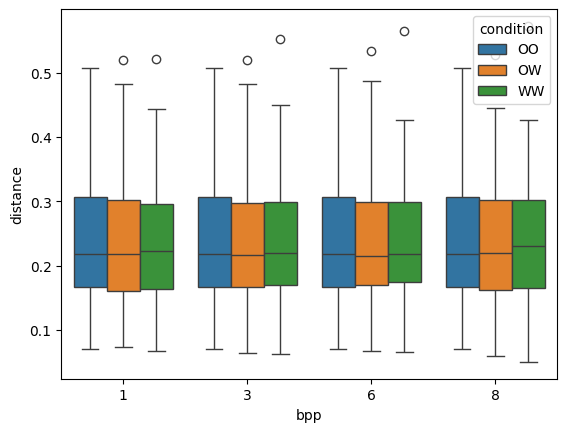

In [30]:
sns.boxplot(data=df_long[(df_long.test_dataset=='ONOT')&(df_long.pair_type=='genuine')], x='bpp', y='distance', hue='condition')

<Axes: xlabel='bpp', ylabel='distance'>

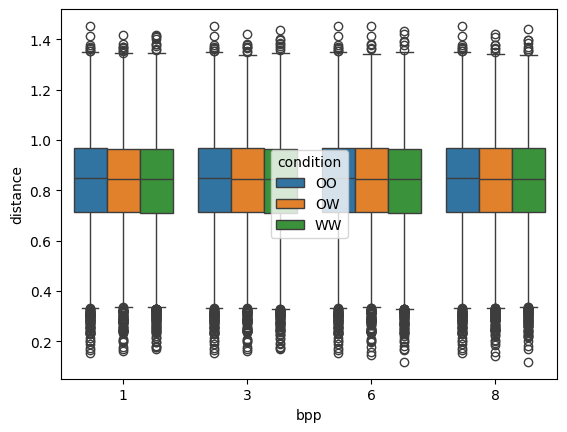

In [31]:
sns.boxplot(data=df_long[(df_long.test_dataset=='ONOT')&(df_long.pair_type=='impostor')], x='bpp', y='distance', hue='condition')

<Axes: xlabel='distance', ylabel='Density'>

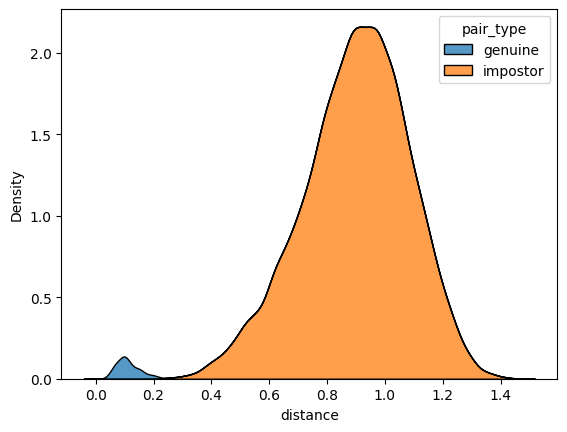

In [33]:
sns.kdeplot(data=df_long[(df_long.test_dataset=='CFD') & (df_long.bpp==8)],
            x='distance', hue='pair_type', multiple='stack')

<Axes: xlabel='distance', ylabel='Density'>

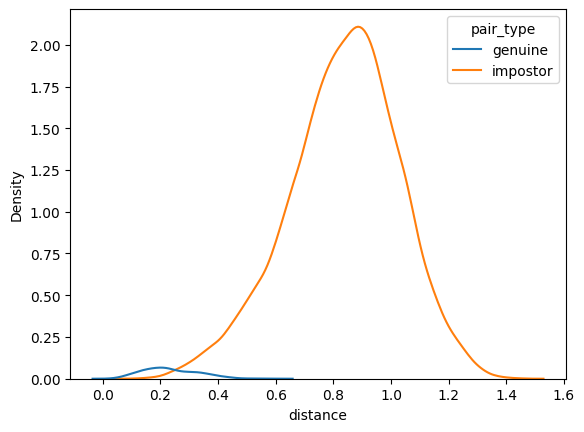

In [59]:
sns.kdeplot(data=df_long[(df_long.test_dataset=='ONOT') & (df_long.bpp==8)],
            x='distance', hue='pair_type', multiple='layer', bw_adjust=1)

<Axes: xlabel='distance', ylabel='Density'>

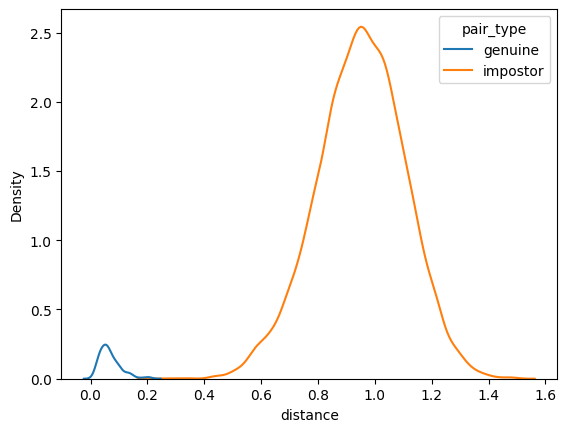

In [52]:
sns.kdeplot(data=df_long[(df_long.test_dataset=='facelab_london') & (df_long.bpp==1)],
            x='distance', hue='pair_type', multiple='layer', bw_adjust=1)

<Axes: xlabel='distance', ylabel='Density'>

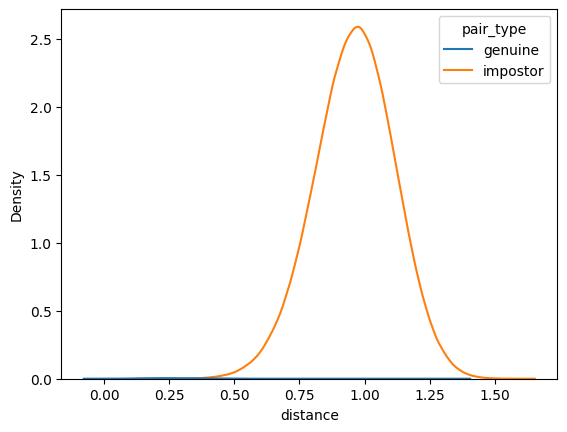

In [51]:
sns.kdeplot(data=df_long[(df_long.test_dataset=='LFW') & (df_long.bpp==1)],
            x='distance', hue='pair_type', multiple='layer', bw_adjust=1)

<Axes: xlabel='distance', ylabel='Density'>

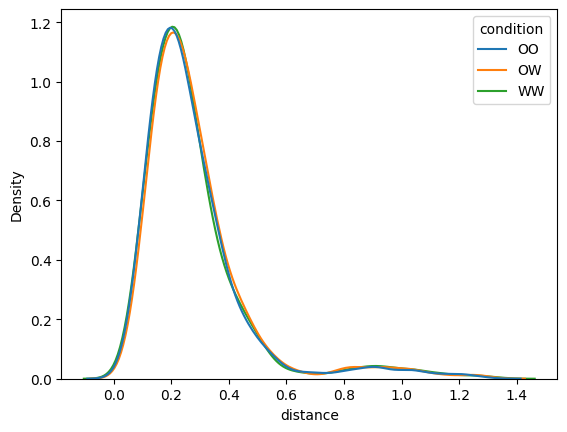

In [49]:
sns.kdeplot(data=df_long[(df_long.test_dataset=='LFW') & (df_long.bpp==8) & (df_long.pair_type=='genuine')],
            x='distance', hue='condition', multiple='layer', bw_adjust=1)

<Axes: xlabel='distance', ylabel='Density'>

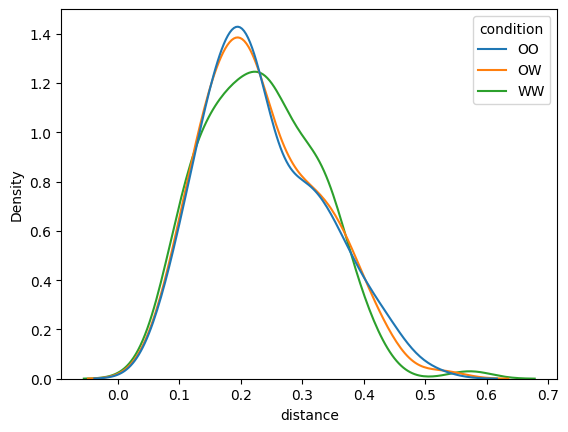

In [65]:
sns.kdeplot(data=df_long[(df_long.test_dataset=='ONOT') & (df_long.bpp==8) & (df_long.pair_type=='genuine')],
            x='distance', hue='condition', multiple='layer', bw_adjust=1)

<Axes: xlabel='distance', ylabel='Density'>

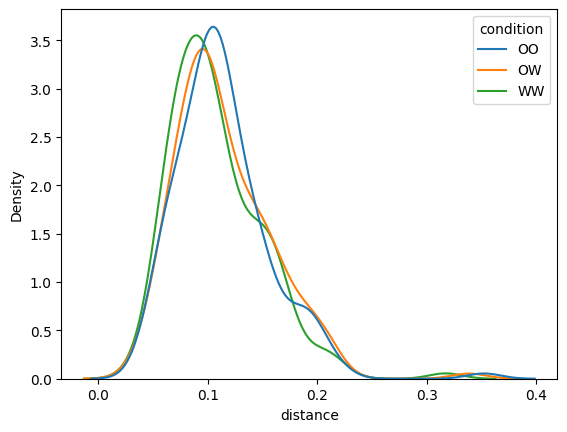

In [64]:
sns.kdeplot(data=df_long[(df_long.test_dataset=='CFD') & (df_long.bpp==8) & (df_long.pair_type=='genuine')],
            x='distance', hue='condition', multiple='layer', bw_adjust=1)

<Axes: xlabel='distance', ylabel='Density'>

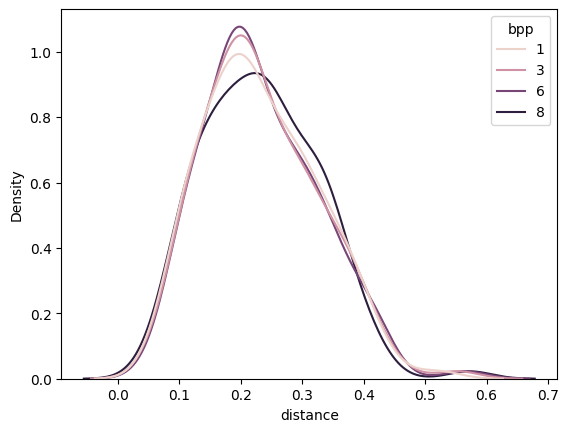

In [55]:
sns.kdeplot(data=df_long[(df_long.test_dataset=='ONOT') & (df_long.pair_type=='genuine') & (df_long.condition=='WW')],
            x='distance', hue='bpp', multiple='layer', bw_adjust=1)

<Axes: xlabel='distance', ylabel='Density'>

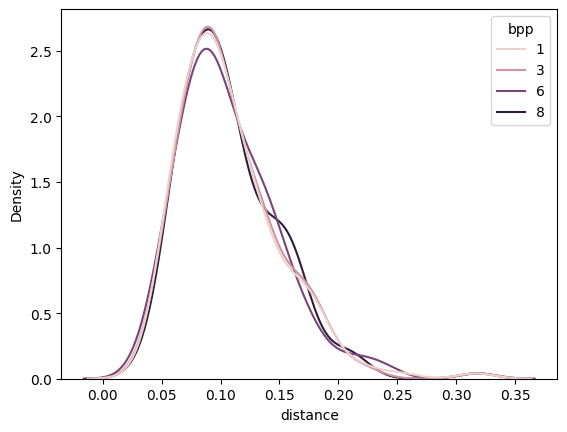

In [66]:
sns.kdeplot(data=df_long[(df_long.test_dataset=='CFD') & (df_long.pair_type=='genuine') & (df_long.condition=='WW')],
            x='distance', hue='bpp', multiple='layer', bw_adjust=1)

In [56]:
import numpy as np
from scipy.stats import gaussian_kde

In [60]:
# Estimar PDFs con KDE

genuine = df_long[(df_long.test_dataset=='ONOT') 
                  & (df_long.bpp==8) 
                  & (df_long.pair_type=='genuine') 
                  & (df_long.condition=='OO')]['distance'].to_numpy()

impostor = df_long[(df_long.test_dataset=='ONOT') 
                   & (df_long.bpp==8)  
                   & (df_long.pair_type=='impostor')
                   & (df_long.condition=='OO')]['distance'].to_numpy()

x = np.linspace(0, 1, 10000)
pdf_g = gaussian_kde(genuine)(x)
pdf_i = gaussian_kde(impostor)(x)

# Calcular el área de solapamiento
overlap = np.trapz(np.minimum(pdf_g, pdf_i), x)
print(f"Overlap: {overlap:.3f}")

Overlap: 0.061


In [61]:
genuine = df_long[(df_long.test_dataset=='ONOT') 
                  & (df_long.bpp==8) 
                  & (df_long.pair_type=='genuine') 
                  & (df_long.condition=='WW')]['distance'].to_numpy()

impostor = df_long[(df_long.test_dataset=='ONOT') 
                   & (df_long.bpp==8)  
                   & (df_long.pair_type=='impostor')
                   & (df_long.condition=='WW')]['distance'].to_numpy()

x = np.linspace(0, 1, 10000)
pdf_g = gaussian_kde(genuine)(x)
pdf_i = gaussian_kde(impostor)(x)

# Calcular el área de solapamiento
overlap = np.trapz(np.minimum(pdf_g, pdf_i), x)
print(f"Overlap: {overlap:.3f}")

Overlap: 0.050


In [ ]:
# impostor threshold para FAR=alpha (alpha=1e-4)
tau = np.quantile(impostor, 0.0001)

# PDFs sobre grilla x
mask = x <= tau
partial_overlap = np.trapz(np.minimum(pdf_g[mask], pdf_i[mask]), x[mask])